In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32
epochs = 50  # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.


In [2]:
# VGG16 modelini yükle (transfer öğrenme)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),  # learning_rate = 0.0002
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_model.keras', save_best_only=True, monitor='val_accuracy')


# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 247s 431ms/step - accuracy: 0.5431 - loss: 2.1112 - val_accuracy: 0.8431 - val_loss: 0.4556
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8119 - loss: 0.6000 - val_accuracy: 0.8469 - val_loss: 0.4098
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 407ms/step - accuracy: 0.8314 - loss: 0.5104 - val_accuracy: 0.8542 - val_loss: 0.3879
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 227s 414ms/step - accuracy: 0.8408 - loss: 0.4610 - val_accuracy: 0.8577 - val_loss: 0.3858
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 406ms/step - accuracy: 0.8431 - loss: 0.4512 - val_accuracy: 0.8629 - val_loss: 0.3685
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8422 - loss: 0.4447 - val_accuracy: 0.8609 - val_loss: 0.3669
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 403ms/step - accuracy: 0.8490 - loss: 0.4277 - val_accuracy: 0.8700 - val_loss: 0.3594
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 219s 399ms/step - accuracy: 0.8541 -

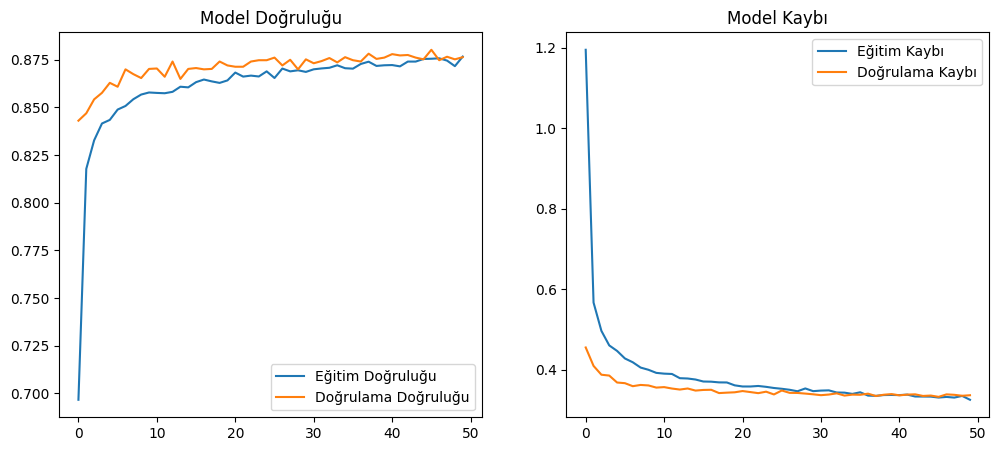

In [4]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

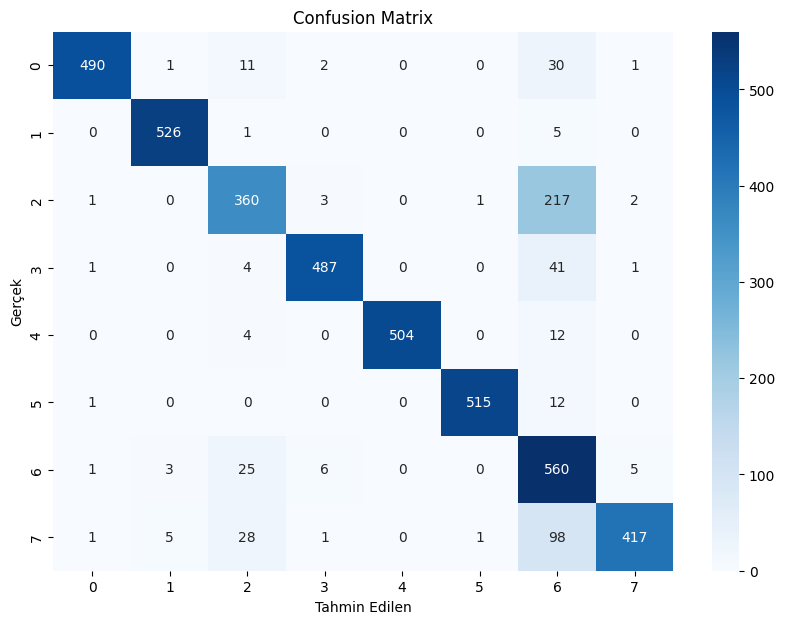

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [6]:
model.save('vgg_model.h5')

Attention

In [2]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Activation

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

In [3]:
from tensorflow.keras.layers import Conv2D, Concatenate

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

In [4]:
from tensorflow.keras.models import Model

# VGG16 modelini yükle (transfer öğrenme)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Base model'in çıktısını al
x = base_model.output

# Channel Attention ekle
x = ChannelAttention()(x)

# Spatial Attention ekle
x = SpatialAttention()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Çıkış katmanı
output = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Yeni modeli oluştur
model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),  # learning_rate = 0.0002
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_attention_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 436ms/step - accuracy: 0.5726 - loss: 1.3112 - val_accuracy: 0.8504 - val_loss: 0.4440
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8317 - loss: 0.5431 - val_accuracy: 0.8650 - val_loss: 0.4011
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 404ms/step - accuracy: 0.8396 - loss: 0.4743 - val_accuracy: 0.8672 - val_loss: 0.3868
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 405ms/step - accuracy: 0.8486 - loss: 0.4357 - val_accuracy: 0.8702 - val_loss: 0.3718
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 226s 411ms/step - accuracy: 0.8491 - loss: 0.4309 - val_accuracy: 0.8714 - val_loss: 0.3651
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 403ms/step - accuracy: 0.8512 - loss: 0.4172 - val_accuracy: 0.8729 - val_loss: 0.3612
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8591 - loss: 0.4029 - val_accuracy: 0.8684 - val_loss: 0.3620
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 219s 399ms/step - accuracy: 0.8568 -

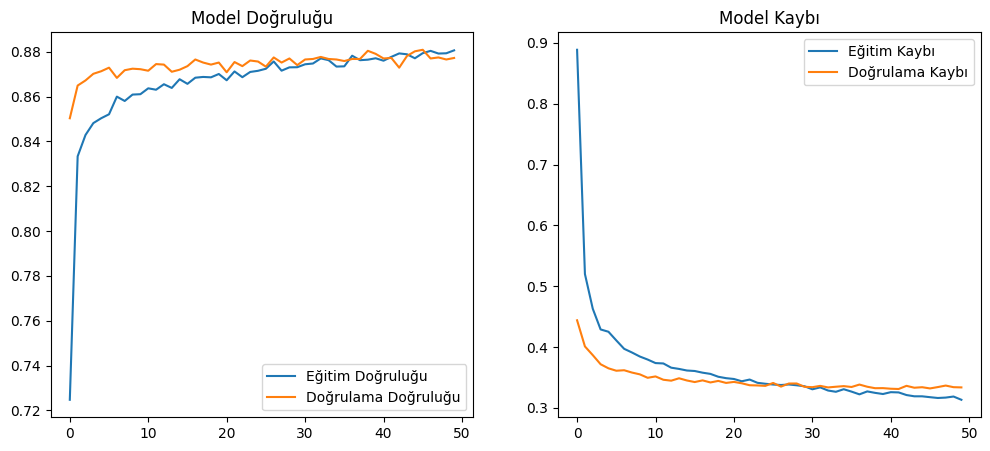

In [6]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

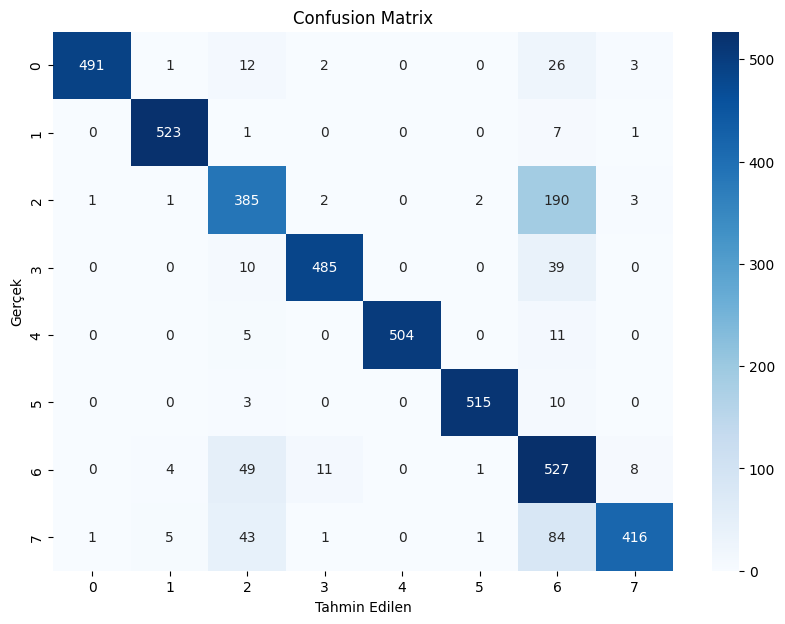

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [8]:
model.save('vgg_att_model.h5')